<center>
    <img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800"> 
</center>  

# Yet another math for DS course: домашнее задание 2

**ФИО:** Вершинин Сергей Владимирович

**Любимый анекдот:** 

## Общая информация


__Дата выдачи:__ 20.11.2023

__Мягкий дедлайн:__ 23:59MSK 10.12.2023

__Жёсткий дедлайн:__ 23:59MSK 17.12.2023

## Формат сдачи

Сам ноутбук называйте в формате hw-02-USERNAME.ipynb, где USERNAME — ваши фамилия и имя. Файл надо будет сдать в anytask.

Это домашнее задание состоит из двух частей: 

- Часть с кодом
- Часть с ручными задачами

Часть с кодом должна быть оформлена на в юпитерской тетрадке. Весь код необходимо писать на python.

Ручную часть можно решать на бумаге и оформить в виде отсканированной pdf-ки с разборчивым почерком. Можно вбить решение в виде формул прямо в юпитерскую тетрадку, можно сделать pdf-ку в техе.

## Часть 1: ручная

За эту часть можно набрать 50 баллов.

Условия задач [лежат по ссылке](https://github.com/FUlyankin/yet_another_math_for_DS/tree/main/hw)

## Часть 2: пишем код

За эту часть вы можете получить 50 обычных баллов и ещё 15 бонусных.

## Задача №1: 50 оттенков градиентного спуска (20 баллов)

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Для наших целей будем использовать искуственно сгенерированные данные.

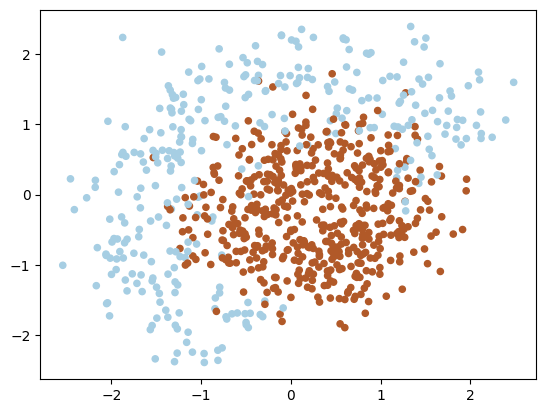

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

__[2 балла]__ Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    r1 = np.hstack((X, X[:,[0]] ** 2, X[:,[1]] ** 2, X[:,[0]] *  X[:,[1]], np.ones(X.shape[0])[:, np.newaxis]))
    return r1

In [4]:
X = expand(X)

__[2 балла]__ Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [5]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: ОДНОМЕРНЫЙ массив весов длины 6
    :returns: ОДНОМЕРНЫЙ массив вероятностей
    """
    return 1/(1 + np.exp(-(w@X.T)))
    # return scipy.special.expit((w@X.T)).reshape(-1,1)

__[2 балла]__ Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [6]:
EPSILON = 1e-9  # чтобы избежать ухода значений log(x) в очень большие 
                # значения будем добавлять к x EPSILON 
 
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    :param X: расширенная матрица объект-признак 
    :param y: ОДНОМЕРНЫЙ массив ответов
    :param w: ОДНОМЕРНЫЙ массив весов
    :return: значение кросс-энтропии
    
    """
    return -np.mean(y * np.log(probability(X,w) + EPSILON) + 
                    (1-y) * np.log(1 - probability(X,w) + EPSILON))

__[2 балла]__ Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^ \ell  (х_i \cdot (\sigma(\langle w, x_i \rangle) - y_i) $$

In [7]:
def compute_grad(X, y, w):
    """
    Находит значение градиента.
    :param X: расширенная матрица объект-признак 
    :param y: ОДНОМЕРНЫЙ массив ответов
    :param w: ОДНОМЕРНЫЙ массив весов
    :return: ОДНОМЕРНЫЙ массив со значение градиента
    """
    l = X.shape[0]
    return  ((probability(X,w)-y) @ X) / l

Функция ниже предназначена для визуализации процесса обучения. 

In [8]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

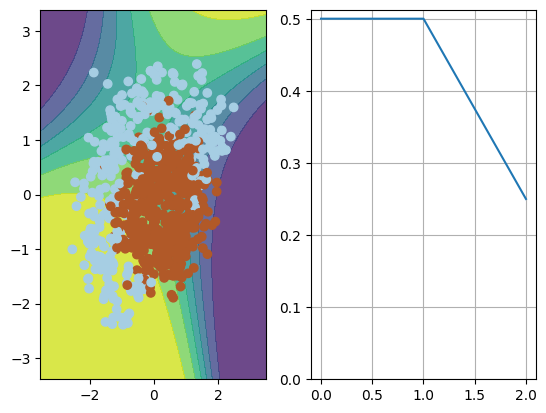

In [9]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

#### __[4 балла]__ Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$

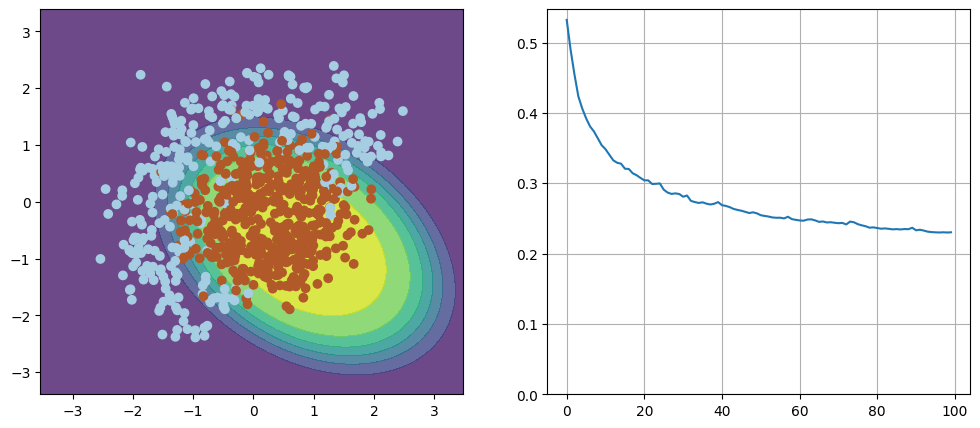

<Figure size 640x480 with 0 Axes>

In [10]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

# при числе итераций в 100 минимум
# достигается при шаге в 0.5. дальнейшее
# увеличение шага уже не приводит к улучшению результата
eta = 0.5 

n_iter = 100
batch_size = 16
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    # т.к. в compute_grad() уже выполняется усреднение градиента по всем объектам, то здесь остается только
    # домножить значение на эту
    w = w - eta*(compute_grad(X[batch_obj_indexes], y[batch_obj_indexes], w))
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

#### __[4 балла]__ Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


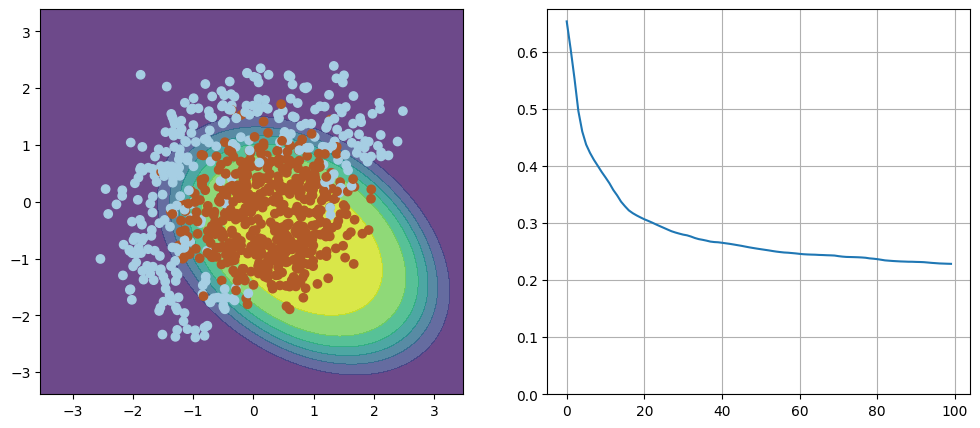

<Figure size 640x480 with 0 Axes>

In [11]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.1 
alpha = 0.8 
v = np.zeros_like(w)

n_iter = 100
batch_size = 16
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    v = alpha * v + eta*(compute_grad(X[batch_obj_indexes], y[batch_obj_indexes], w))
    w = w - v
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

#### __[4 балла]__ RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$


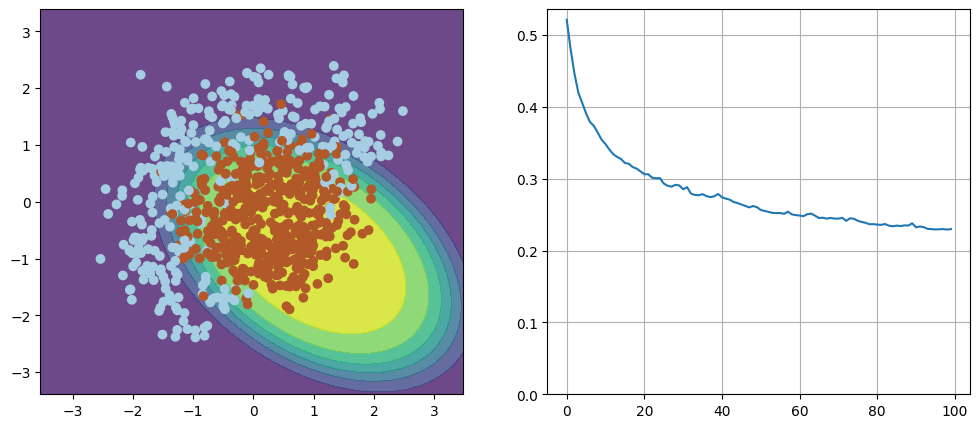

<Figure size 640x480 with 0 Axes>

In [12]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.05 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 16
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(X[batch_obj_indexes],y[batch_obj_indexes],w)
    g2 = alpha*g2 + (1-alpha)*grad**2
    w = w - eta/np.sqrt(g2+eps)*grad
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

__[бонусные 5]__ Реализуйте Adam

Adam основан на вычислении экспоненциального скользящего среднего как градиентов, так и их квадратов, чтобы адаптивно регулировать скорости обучения. Параметры $\beta_1$ и $\beta_2$ контролируют скорости затухания оценок моментов. Обычно рекомендуют делать $\beta_1$ = 0.9, $\beta_2$ = 0.999. [https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar/](https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar/).


$$\begin{equation}
    m_t = \beta_1{m_{t-1}} + (1 - \beta_1)g_t
  \end{equation}$$
  
$$\begin{equation}
    \upsilon_t = \beta_2{\upsilon_{t-1}} + (1 - \beta_2)g_t^2
  \end{equation}$$
  
$$\begin{equation}
    \hat{m_t} = \frac{m_t}{1 - \beta_1^t}
  \end{equation}$$
$$\begin{equation}
    \hat{\upsilon_t} = \frac{\upsilon_t}{1 - \beta_2^t}
  \end{equation}$$
 
$$ w_{t} = w_{t-1} - \frac {\eta}{\sqrt{\hat{\upsilon_t}} + \epsilon} \hat{m_t}$$

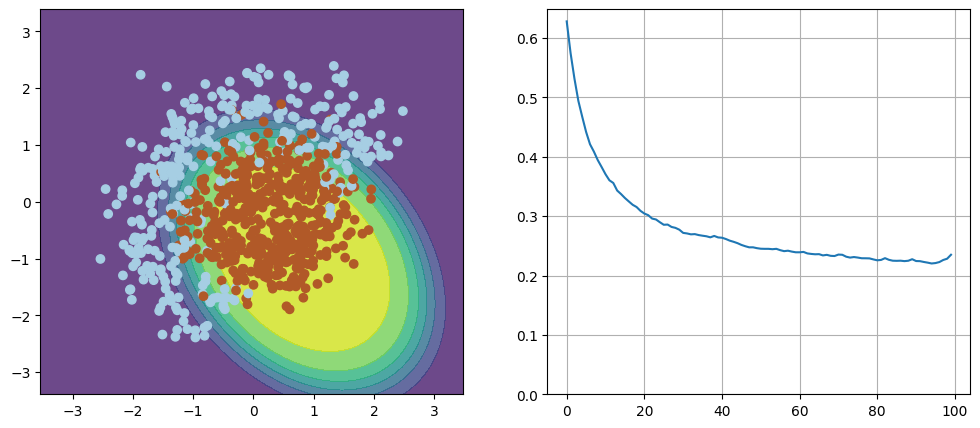

<Figure size 640x480 with 0 Axes>

In [13]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.05 
"""в нашем случае при рекомендуемых beta1=0.9 и beta2=0.999 Adam очень быстро сходится какому-то 
 локальному минимуму и не хочет из него выходить, а вот установка этих параметров в 0.1 меняет 
 картину и позволяет найти примерно тот же минимум, что находили алгоритмы выше"""
beta1 = 0.1
beta2 = 0.1 
m = np.zeros_like(w)
v = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 32
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(X[batch_obj_indexes],y[batch_obj_indexes],w)
    t = i+1
    m = (beta1*m + (1-beta1)*grad) / (1 - beta1**t)
    v = (beta2*v + (1-beta2)*grad**2)  / (1 - beta2**t)
    w = w - (eta*m / (np.sqrt(v)+eps))
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

__[бонусные 5]__ Выясните что такое метод Ньютона (метод второго порядка) и реализуйте его.

Для оптимизации методом Ньютона вычисление весов на каждой итерации выполняется по следующей формуле:
$$\mathbf{w}_{t} = \mathbf{w}_{t-1} - [\mathbf{H_w}L(w_t, x_{i_j}, y_{i_j})]^{-1} \nabla_w L(w_t, x_{i_j}, y_{i_j}),$$ 
где $\mathbf{H_w}L(w_t, x_{i_j}, y_{i_j})$ - гессиан, который может быть рассчитан как:
$$\\{H_w}L(w_t, x_{i_j}, y_{i_j})=X^TDX,$$
где $D$ - диагональная матрица с элементами $D_{ii}=\sigma(\langle w, x_i\rangle)(1-\sigma(\langle w, x_i\rangle))$

Обоснование метода и вывод формул можно найти [здесь](https://stats.stackexchange.com/questions/253632/why-is-newtons-method-not-widely-used-in-machine-learning#answer-301728) и [здесь](https://stats.stackexchange.com/questions/68391/hessian-of-logistic-function#answer-316933) 
 

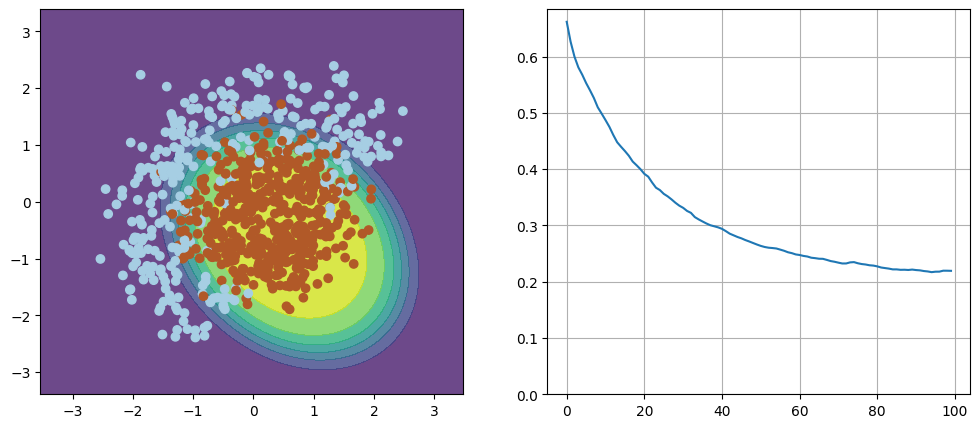

<Figure size 640x480 with 0 Axes>

In [14]:
from numpy.linalg import inv

np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])


n_iter = 100
batch_size = 32
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    grad = compute_grad(X[batch_obj_indexes],y[batch_obj_indexes],w)
    sigm = probability(X[batch_obj_indexes], w)
    D = np.diag(sigm * (1 - sigm))
    # поскольку формулы выведены для w и gradient представленных как векторы-столбцы, порядок умножений в 
    # коде отличается 
    w = w - grad @ inv(X[batch_obj_indexes].T @ D @ X[batch_obj_indexes])  
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

__[бонусные 5]__ Выясните, что такое weight decay и реализуйте его для базовой версии SGD. Правда ли, что эта модернизация улучшает обучение?

*Weight decay* — это метод регуляризации, который используется для нормализации размеров весов определенных параметров в моделях машинного обучения. Weight decay является наиболее широко используемым методом регуляризации для параметрических моделей машинного обучения. Weight decay **также известен как L2-регуляризация**, потому что он штрафует веса в соответствии с их L2-нормой. В методе weight decay целевая функция, минимизирующая потери предсказания на обучающих данных, заменяется новой целевой функцией, минимизирующей сумму потерь предсказания и штрафной компоненты. Она дополнительно включает в себя компоненту, пропорциональную сумме квадратов весов. Вот как выглядит новая функция потерь с использованием метода weight decay:
 $$ L_{reg}(w_t, x_{i_j}, y_{i_j}) = L(w_t, x_{i_j}, y_{i_j}) + \dfrac{\lambda}{2} ||\boldsymbol w||^2$$
 
Соответственно, градиет новой функции будет равен
$$ \nabla_w L_{reg}(w_t, x_{i_j}, y_{i_j}) = \nabla_w L(w_t, x_{i_j}, y_{i_j}) + \lambda w $$ 

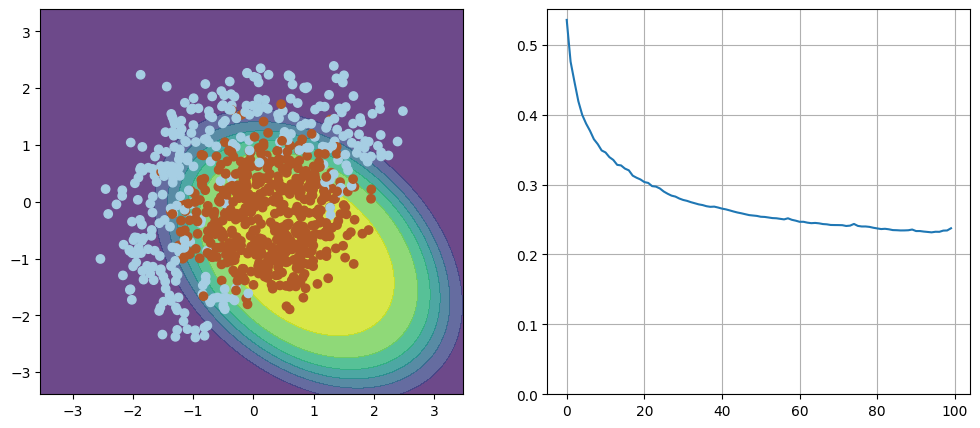

<Figure size 640x480 with 0 Axes>

In [15]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.5 
"""Эксперименты с коэффициентом alpha показывают, что сходимость лучше при меньших значениях, 
фактически снижающих роль штрафной компоненты в формуле функции потерь. Представляется, что 
в случае с нашей выборкой weight decay значимого эффекта не дает"""
alpha = 0.001

n_iter = 100
batch_size = 32
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    batch_obj_indexes = np.random.choice(X.shape[0], batch_size, replace=False)
    w = w - eta*(compute_grad(X[batch_obj_indexes], y[batch_obj_indexes], w) + alpha * w)
    loss[i] = compute_loss(X,y,w)

visualize(X, y, w, loss)
plt.clf()

## Задача №2: SVD (30 баллов)

Напомним, что сингулярным разложением (SVD, Singular value decomposition) матрицы $A$ размера $m\times n$ называется представление

$$A = U\Sigma V^T,$$

где $U$ — ортогональная матрица размера $m\times m$, $V$ — ортогональная матрица размера $n\times n$, $\Sigma = \mathrm{diag}(\sigma_1,\sigma_2,\sigma_3,\ldots)$ — диагональная матрица размера $m\times n$, в которой $\sigma_1\geqslant\sigma_2\geqslant\ldots\geqslant0$.

На самом деле требование, чтобы матрицы $U$ и $V$ были квадратными, избыточно. *Усечённым сингулярным разложением* мы будем называть разложение

$$A = U\Sigma V^T,$$

где $U$ и $V$ — матрицы с ортонормированными столбцами размеров $m\times k$ и $n \times k$ соответственно, $\Sigma$ — диагональная матрица размера $k\times k$, где $k = \min(m,n)$. Далее мы будем работать исключительно с усечённым разложением.

### Сжатие данных с помощью SVD = построение низкорангового приближения

Введём *норму Фробениуса* матрицы как

$$||A||_{frob} = \sqrt{\mathrm{tr}{A^TA}} = \sqrt{\sum\limits_{i,j}a^2_{i,j}}$$

Иными словами, это обычное евклидово расстояние на пространстве, которое получается, если все матрицы вытянуть в длинные векторы.

Зададимся вопросом: как найти матрицу $A_{r}$ ранга $r$, наименее отличающуюся от $A$ по норме Фробениуса (то есть для которой норма разности $||A - A_{r}||_{frob}$ минимальна). Оказывается, это можно сделать с помощью сингулярного разложения:

**Теорема.** Пусть $\Sigma_{r}$ — это матрица, полученная из $\Sigma$ заменой диагональных элементов $\sigma_{i}$ ($i > r$) нулями, тогда $A_{r} = U\Sigma_{r}V^T$.

Это можно переписать и в более экономичном виде. Если

$$A = \underbrace{
\begin{pmatrix}
u_{11} & \ldots & u_{1k}\\
\vdots & & \vdots\\
u_{m1} & \ldots & u_{mk}
\end{pmatrix}}_{=U}\cdot\underbrace{{
\begin{pmatrix}
\sigma_{1} & &\\
 & \sigma_{2} & \\
 & & \ddots
\end{pmatrix}}
}_{=\Sigma}\cdot \underbrace{
\begin{pmatrix}
v_{11} & \ldots & v_{n1}\\
\vdots & & \vdots\\
v_{1k} & \ldots & v_{nk}
\end{pmatrix}}_{=V^T}$$

то

$$A_{r} = \underbrace{
\begin{pmatrix}
u_{11} & \ldots & u_{1r}\\
\vdots & & \vdots\\
u_{m1} & \ldots & u_{mr}
\end{pmatrix}}_{=U_r}\cdot\underbrace{{
\begin{pmatrix}
\sigma_{1} & &\\
 & \ddots & \\
 & & \sigma_{r}
\end{pmatrix}}
}_{=\Sigma_r}\cdot \underbrace{
\begin{pmatrix}
v_{11} & \ldots & v_{n1}\\
\vdots & & \vdots\\
v_{1r} & \ldots & v_{nr}
\end{pmatrix}}_{=V^T_r}$$

При этом

$$||A - A_{r}||_{frob} = \sqrt{\sum\limits_{i\geqslant r+1} \sigma_{i}^2}$$

Если сингулярные значения матрицы падают достаточно быстро (а в реальных задачах часто бывает именно так), то норма разности будет малой при сравнительно небольшом значении $r$.

На хранение исходной матрицы нам требовалось $m\times n$ памяти. Теперь же, если мы будем хранить отдельно $U_r$, $V_r$ и диагональные элементы $\Sigma_r$, затраты памяти составят $mr + nr + r = r(m + n + 1)$.

**Разложение на компоненты ранга 1**

Обозначим через $u_1,\ldots, u_k$ столбцы матрицы $U$, а через $v_1, \ldots, v_k$ столбцы матрицы $V$. Тогда имеет место равенство

$$A = u_1\sigma_{1}v_1^T + u_2\sigma_{2}v_2^T + u_3\sigma_{3}v_3^T + \ldots$$

Матрицу $u_k\sigma_{k}v_k^T = \sigma_{k}u_kv_k^T$ мы будем называть $k$-й компонентой ранга 1 матрицы $A$. Отметим, что слагаемые в этой сумме ортогональны относительно скалярного произведения $(X, Y) = \mathrm{tr}(X^TY)$ (порождающего норму Фробениуса).

Как нетрудно заметить,

$$A_{r} = \sigma_{1}u_1v_1^T + \sigma_{2}u_2v_2^T + \ldots + \sigma_{r}u_rv_r^T$$

**Геометрический смысл SVD**

Допустим, что у нас есть выборка $x_1,\ldots,x_m\in\mathbb{R}^n$. Запишем её в матрицу объекты-признаки

$$X = \begin{pmatrix}
x_{11} & \ldots & x_{1n}\\
\vdots & & \vdots\\
x_{m1} & \ldots & x_{mn}
\end{pmatrix}$$

(строки — объекты, столбцы — признаки) и сделаем SVD-разложение: $X = U\Sigma V^T$. Его можно интерпретировать следующим образом:

$$X = U\Sigma\cdot V^T,$$

где $U\Sigma$ — это матрица объекты-признаки для тех же объектов, но в новых признаках, полученных из исходных с помощью линейного преобразования $V$ (напоминаем, что умножение на матрицу справа соответствует преобразованию столбцов). Попробуем понять, чем замечательны эти признаки.

Рассмотрим матрицу $X^TX = V\Sigma^2V^T$. Легко видеть, что это матрица Грама системы столбцов матрицы $X$; иными словами, в ней записаны скалярные произведения векторов различных признаков. Из лекций вы знаете, что $\sigma_1^2$, квадрат первого сингулярного числа, это наибольшее собственное значение матрицы $X^TX$, а $v_1$, первый столбец матрицы $V$, — это соответствующий собственный вектор. Можно показать, что

$$\sigma_1 = \mathrm{max}_{w}\frac{|Xw|}{|w|} = \mathrm{max}_{|w| = 1}\left(|Xw|\right).$$

Попробуем осознать физический смысл этой штуки. Напомним, что строки матрицы $X$ — это координаты объектов $x_1,\ldots,x_m$ в пространстве признаков. Произведение $Xw$ — это вектор из значений на тех же самых объектах некоторого нового признака, являющегося линейной комбинацией исходных с коэффициентами $w_1,\ldots,w_n$:

$$Xw = w_1\begin{pmatrix} x_{11}\\ \ldots \\ x_{m1}
\end{pmatrix} + w_2\begin{pmatrix} x_{12}\\ \ldots \\ x_{m2}
\end{pmatrix} + \ldots + w_n\begin{pmatrix} x_{1n}\\ \ldots \\ x_{mn}
\end{pmatrix}$$

Соответственно, $|Xw|^2$ — это квадрат длины вектора, составленного из значений нового признака.

Таким образом, первому сингулярному значению $\sigma_1$ отвечает такой признак, у которого сумма квадратов значений максимальна, то есть признак, принимающий, условно говоря, самые большие значения.

Резюмируя, мы можем сказать, что сингулярное разложение делает следующее:
- находит новый признак (новое направление) вдоль которого "дисперсия" максимальна;
- в ортогональной ему плоскости находит признак, вдоль которого "дисперсия" максимальна;
- и так далее.

**Технические детали (SVD в Питоне)**

Есть несколько способов сделать в Питоне сингулярное разложение; мы пока предлагаем Вам использовать

`import scipy.linalg as sla`

`U, S, Vt = sla.svd(X, full_matrices=False)`

Для ознакомления с особенностями этой функции рекомендуем обратиться к [документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) (в частности, обратите внимание на то, какие именно объекты она возвращает).

Попробуем поработать с какой-нибудь картинкой.

In [ ]:
!pip3 install opencv-python

In [ ]:
import cv2 as cv
img = cv.imread("data/chain_small.jpg")
img.shape

In [ ]:
img = img.mean(axis=2) # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD
img.shape

Нарисуем картинку.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

imgplot = plt.imshow(img, cmap='gray')

Построим сингулярное разложение этой матрицы.

In [ ]:
from numpy.linalg import svd

U, S, VT = svd(img, full_matrices=False)

__[4 балла]__ Нарисуйте график диагональных элементов матрицы $\Sigma$:

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

Кажется, что они убывают достаточно быстро и есть надежда, что первые несколько компонент дадут картинку, близкую к исходной.

**Важно:** при визуализации различных компонент в этом задании используйте только матричные операции. В частности, избегайте циклов, функций `map` и `reduce`, а также специальных функций, находящих суммы компонент.

__[4 балла]__ Визуализуйте первую компоненту ранга 1. Ожидали ли Вы увидеть именно это? Поясните.

In [ ]:
# your code here
# [✖‿✖]

__[4 балла]__  Визуализуйте суммы компонент ранга 1 с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Сделайте выводы.

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

__[2 балла]__  Как Вам кажется, какие компоненты нужно взять для достаточно хорошего восстановления исходного изображения? Аргументируйте свой ответ. Не забудьте визуализировать сумму выбранных компонент.

*Комментарий: для получения полного балла за это задания постарайтесь привести более убедительный аргумент, нежели Ваши субъективные впечатления от сравнения полученного изображения с исходным.*

> __Ответ:__ Ваш ответ буквами прям в маркдауне:3 

In [ ]:
# your code here
# ( .-. )

__[2 балла]__ Во сколько раз меньше памяти (теоретически) потребуется для хранения нового изображения по сравнению с исходным?

> __Ответ:__ Ваш ответ буквами прям в маркдауне:3 

__[1 балл]__ Подсчитайте, сколько в действительности места в памяти компьютера занимают исходная матрица и компоненты её сингулярного разложения. Согласуется ли этот результат с ответом предыдущего пункта? Сделайте выводы.

_Hint:_ достаточно сохранить да файла на компьютер в `.np` формате и сравнить их вес между собой. 

> __Ответ:__ Ваш ответ буквами прям в маркдауне:3 

Первые из "новых" признаков — это признаки, значения которых, скажем так, наиболее разнообразны. Зачастую (хотя и не всегда) именно они несут в себе наиболее важные черты датасета. И если взять два-три первых, то датасет можно нарисовать и посмотреть на него — и, возможно, обнаружить какую-то структуру.

С помощью функции `dsklearn.datasets.load_digits()` загрузите датасет рукописных цифр [MNIST](http://yann.lecun.com/exdb/mnist/). В нём есть несколько атрибутов; вам сейчас будут нужны `digits.data` (`np.array`, строки которого — это вытянутые в одну строку значения пикселей) и `digits.target` (в них записаны соответствующие цифры).

In [ ]:
from sklearn import datasets

digits = datasets.load_digits()

print(digits.target[0])

plt.imshow(digits.data[0].reshape((8,8)))

__[3 балла]__ Примените к матрице `digits.data` сингулярное разложение.

In [ ]:
# your code here
# (⌐■_■)

__[2 балла]__  Визуализируйте данные, спроецировав их на такую плоскость, чтобы координаты точек соответствовали первым двум новым признакам. Не забудьте покрасить точки, отвечающие различным цифрам, в разные цвета (если Вы любите красивые визуализации, разберитесь, как вместо точек рисовать маленькие цифры).

In [ ]:
# your code here
# (❍ᴥ❍ʋ)

__[2 балла]__  Теперь вычтите из каждого признака его среднее значение, снова сделайте SVD и нарисуйте разноцветные точки.

In [ ]:
# your code here
# [̲̅$̲̅(̲̅5̲̅)̲̅$̲̅]

__[2 балла]__  Сравните выполненные Вами в двух предыдущих пунктах визуализации. Чем последняя выгодно отличается от первой?

In [ ]:
# your code here
#  ლ(ಠ益ಠლ)

__[4 балла]__  Сравните работу SVD с другим методом понижения размерности: [случайными гауссовскими проекциями](http://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html).

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ

*Комментарий: Эксперименты без выводов, объясняющих полученные результаты, не оцениваются. Для получения полного балла за этот пункт постарайтесь провести как можно больше разноплановых экспериментов.*